In [41]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [49]:
# Utility procs
def get_image(path, img_transform, size = (300, 300)):
    image = Image.open(path)
    image = image.resize(size, Image.LANCZOS) # method available for Image object
    image = img_transform(image).unsqueeze(0) # add dimension at 0
    # Add batch size. Pytorch expects batch size for proper functioning
    return image

def get_gram(m):
    """"
    m: (1, Channels, Height, Width)
    """
    _, c, h, w = m.size() # b, c, h, w
    m = m.view(c, h * w)
    m = torch.mm(m, m.t())
    return m

def denormalize_img(ip):
    ip = ip.numpy().transpose((1,2,0)) # ip: c, h, w -> h, w, c (in pytorch channels at begining, in numpy channels should be at the end)
    mean = np.array([0.485, 0.456, 0.406]) # means of image net 
    std = np.array([0.229, 0.224, 0.225]) # stds of image net
    ip = ip*std + mean
    ip = np.clip(ip, 0, 1)

    return ip

In [43]:
# Model
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.selected_layers = ['3', '8', '15', '22']
        self.vgg = models.vgg16(pretrained=True).features # list of layers
    
    def forward(self, x):
        layer_features = []
        for layer_num, layer in self.vgg._modules.items(): # iterable on the ordered dict of layers in VGG
            x = layer(x)
            if layer_num in self.selected_layers:
                layer_features.append(x)  # save the ouputs of chosen layers
        return layer_features

In [44]:
vgg = models.vgg16(pretrained=True)
vgg.features._modules.items()

/nfs/site/home/abalusan/work_dir_1/courses/.course_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/nfs/site/home/abalusan/work_dir_1/courses/.course_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


odict_items([('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('1', ReLU(inplace=True)), ('2', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('3', ReLU(inplace=True)), ('4', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('5', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('6', ReLU(inplace=True)), ('7', Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('8', ReLU(inplace=True)), ('9', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('10', Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('11', ReLU(inplace=True)), ('12', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('13', ReLU(inplace=True)), ('14', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('15', ReLU(inplace=True)), ('16', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('17', Conv2d(25

In [45]:
# Transform the image. to tensor, normalize etc.
img_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

content_img = get_image('15.intel_foco.jpg', img_transform)
style_img = get_image('15.shades_of_blue.jpg', img_transform)
generated_img = content_img.clone()
generated_img.requires_grad = True # The pixels in the image are the trainable parameters

# The following is the hard way. Since the FloatTensor returns a random tensor. It would be easier if we start from the content image and make the N/W's life easier
# generated_img = nn.Parameter(torch.FloatTensor(content_img.size())) # define the learnable parameters. Not layers, just learnable parameters.

optimizer = torch.optim.Adam([generated_img], lr = 0.003, betas = [0.5, 0.999]) # hyperparam from paper. They tested and mentioned that these work best. 
encoder = FeatureExtractor()

#Freeze the parameter
for p in encoder.parameters():
    p.requires_grad = False

# an easier way is to set it to eval mode: 
# encoder.eval() to freeze weights.

In [46]:
# Weights based on paper. 
content_wt = 1
style_wt = 100

for epoch in range(500):

    # encode content, generated and style images to get features
    content_features = encoder(content_img)
    style_features = encoder(style_img)
    generated_features = encoder(generated_img)

    # For content we only take the output of the last layer
    content_loss = torch.mean((content_features[-1] - generated_features[-1])**2)

    style_loss = 0

    for gf, sf in zip(generated_features, style_features):
        _, c, h, w = gf.size()
        gram_gf = get_gram(gf)
        gram_sf = get_gram(sf)
        # add style loss across the selected layers
        style_loss += torch.mean((gram_gf - gram_sf)**2) / (c*h*w) # NN doesn't do well w/ large values. So normalize based on size for numrical stability. 

    loss = content_wt * content_loss + style_wt * style_loss 

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"{epoch =} \t  Content Loss: {content_loss.item():.4f}\t Style Loss: {style_loss.item():.4f}")

epoch =0 	  Content Loss: 0.0000	 Style Loss: 2273.4541
epoch =10 	  Content Loss: 0.3377	 Style Loss: 2051.8103
epoch =20 	  Content Loss: 0.6977	 Style Loss: 1799.7478
epoch =30 	  Content Loss: 0.9598	 Style Loss: 1594.8499
epoch =40 	  Content Loss: 1.1181	 Style Loss: 1446.0288
epoch =50 	  Content Loss: 1.2249	 Style Loss: 1331.2195
epoch =60 	  Content Loss: 1.3004	 Style Loss: 1235.2484
epoch =70 	  Content Loss: 1.3560	 Style Loss: 1151.2258
epoch =80 	  Content Loss: 1.4004	 Style Loss: 1075.6312
epoch =90 	  Content Loss: 1.4401	 Style Loss: 1006.4526
epoch =100 	  Content Loss: 1.4750	 Style Loss: 942.4027
epoch =110 	  Content Loss: 1.5044	 Style Loss: 882.5434
epoch =120 	  Content Loss: 1.5335	 Style Loss: 826.2211
epoch =130 	  Content Loss: 1.5593	 Style Loss: 772.9886
epoch =140 	  Content Loss: 1.5822	 Style Loss: 722.4856
epoch =150 	  Content Loss: 1.6029	 Style Loss: 674.4960
epoch =160 	  Content Loss: 1.6232	 Style Loss: 628.8811
epoch =170 	  Content Loss: 1.64

(-0.5, 299.5, 299.5, -0.5)

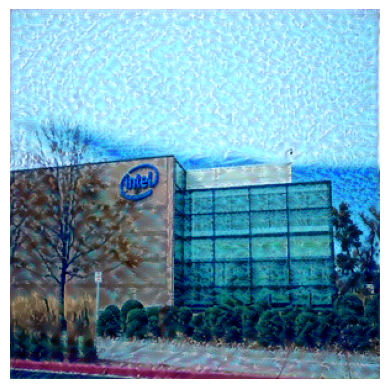

In [51]:
gen_img = generated_img.detach().squeeze()
gen_img = denormalize_img(gen_img)
plt.imshow(gen_img)
plt.axis('off')

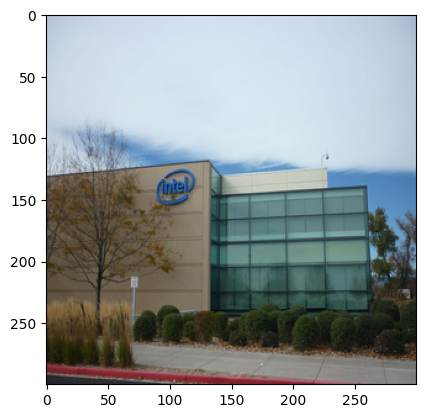

In [56]:
plt.imshow(denormalize_img(content_img.squeeze()))